In [4]:
!pip install transformers datasets pandas


In [9]:
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
import pandas as pd
from datasets import Dataset
import os

os.environ['HF_TOKEN'] = 'your_huggingface_token_here'

model_name = "gpt2"
model = AutoModelForCausalLM.from_pretrained(model_name, token=os.environ['HF_TOKEN'])
tokenizer = AutoTokenizer.from_pretrained(model_name, token=os.environ['HF_TOKEN'])

tokenizer.pad_token = tokenizer.eos_token

df = pd.read_csv('/content/impression_300_llm.csv')
dataset = Dataset.from_pandas(df)

def tokenize_function(examples):
    inputs = tokenizer(examples['Report Name'], examples['History'], examples['Observation'], truncation=True, padding=True)
    inputs['labels'] = inputs['input_ids'].copy()
    return inputs

tokenized_dataset = dataset.map(tokenize_function, batched=True)

training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=8,
    num_train_epochs=3
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset.train_test_split(test_size=30)['train'],
    eval_dataset=tokenized_dataset.train_test_split(test_size=30)['test']
)

trainer.train()

model.save_pretrained("./fine-tuned-model")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/330 [00:00<?, ? examples/s]

Step,Training Loss


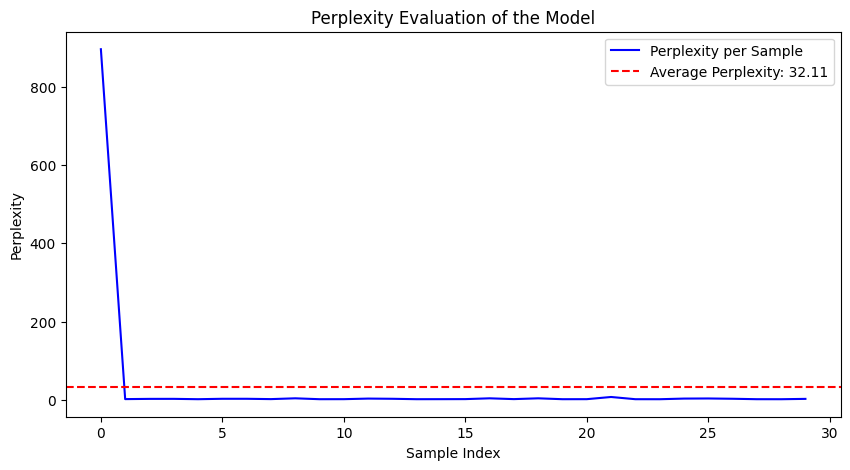

The model 'GPT2LMHeadModel' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForSequenceClassification', 'ErnieForSequenceClassification', 'ErnieMForSequenceClassification', 'EsmForSequenceClassification', 'FalconForSequenceClassification', 'FlaubertForSequenceClassification', 'FNetForSequenceClassification', 'FunnelForSequenceClassification', 'GemmaForSequenceClassification', 'Gemma2ForSequenc

Error analyzing text: CT KUB Plain - Male
Error: 71638

Error analyzing text: MRI Spine Lumbo Sacral Plain
Error: 152898

Error analyzing text: MRI Spine Cervical Plain
Error: 201633

Error analyzing text: CT Thorax Plain and Contrast
Error: 248039

Error analyzing text: CT Abdomen & Pelvis Plain and Contrast - Female
Error: 449067



In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import pipeline

model = AutoModelForCausalLM.from_pretrained("./fine-tuned-model")
tokenizer = AutoTokenizer.from_pretrained(model_name)

def calculate_perplexity(text):
    tokenizer.pad_token = tokenizer.eos_token
    inputs = tokenizer(text, return_tensors='pt', padding='longest', truncation=True)
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs['input_ids'])
        log_likelihood = outputs.loss.item()
    perplexity = np.exp(log_likelihood)
    return perplexity


perplexities = []
eval_texts = tokenized_dataset.train_test_split(test_size=30)['test']['Report Name']

for text in eval_texts:
    perplexity = calculate_perplexity(text)
    perplexities.append(perplexity)

average_perplexity = np.mean(perplexities)

plt.figure(figsize=(10, 5))
plt.plot(perplexities, label='Perplexity per Sample', color='blue')
plt.axhline(y=average_perplexity, color='red', linestyle='--', label=f'Average Perplexity: {average_perplexity:.2f}')
plt.title('Perplexity Evaluation of the Model')
plt.xlabel('Sample Index')
plt.ylabel('Perplexity')
plt.legend()
plt.show()

text_analysis_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer)

sample_texts = eval_texts[:5]
for text in sample_texts:
    try:
        analysis = text_analysis_pipeline(text)
        print(f'Text: {text}\nAnalysis: {analysis}\n')
    except Exception as e:
        print(f'Error analyzing text: {text}\nError: {str(e)}\n')

# New Section